This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import ttest_ind

In [2]:
# set the path to the data
sum_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/sum_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
sum_aggregated_data_pca = pd.read_parquet(sum_aggregated_data_pca_path)
print(sum_aggregated_data_pca.shape)
sum_aggregated_data_pca.head()

(42, 44)


,Metadata_genotype,Metadata_replicate,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42
0,High-Severity,1,-2.612687,2.480900,1.038433,-2.124206,1.848401,-0.138879,0.610879,-1.240955,...,1.737607,0.665385,-1.508575,-0.002393,-1.269638,0.005696,0.640564,0.873191,-0.304305,-9.020562e-16
1,High-Severity,10,1.744949,8.499953,2.922399,-1.102377,-0.962470,1.636088,1.463812,2.400998,...,-0.030647,0.118004,-1.435196,2.127940,-0.683266,-0.594841,-0.847429,-0.543167,0.226587,-6.106227e-16
2,High-Severity,11,1.118178,10.555786,1.918724,-1.821125,1.678552,-0.607047,-1.070299,-0.952239,...,0.164507,1.273944,0.585109,0.301258,-0.100187,0.409482,0.292690,-0.419133,0.090811,-1.665335e-16
3,High-Severity,12,-0.267551,7.238575,3.193898,-0.921462,-1.421467,3.201197,0.876403,1.133883,...,-0.788146,0.724145,-0.588942,0.030300,0.712927,0.415672,2.116853,-0.583968,0.414338,-6.661338e-16
4,High-Severity,13,-0.810176,6.274105,4.030843,0.668752,-0.999091,3.636388,0.282499,-2.773985,...,-1.040199,-1.076102,-0.000303,-0.058833,-0.736013,0.174054,-0.917179,1.114349,0.339969,3.400058e-16


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA components 1 and 2
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = sum_aggregated_data_pca[
    sum_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

14 14 14


In [4]:
# drop the the Metadata columns
high_severity = high_severity.drop(columns=["Metadata_genotype", "Metadata_replicate"])
low_severity = low_severity.drop(columns=["Metadata_genotype", "Metadata_replicate"])
wt = wt.drop(columns=["Metadata_genotype", "Metadata_replicate"])
# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(14, 42) (14, 42) (14, 42)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 7.874466036404469


/home/lippincm/miniconda3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 6.549257169182537


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 10.91040663213425


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                                                                                                          | 0/1000 [00:00<?, ?it/s]

  0%|                                                                                                                  | 1/1000 [00:00<02:55,  5.69it/s]

  0%|▏                                                                                                                 | 2/1000 [00:00<02:37,  6.33it/s]

  0%|▎                                                                                                                 | 3/1000 [00:00<02:31,  6.57it/s]

  0%|▍                                                                                                                 | 4/1000 [00:00<02:33,  6.48it/s]

  0%|▌                                                                                                                 | 5/1000 [00:00<02:30,  6.61it/s]

  1%|▋                                                                                                                 | 6/1000 [00:00<02:28,  6.71it/s]

  1%|▊                                                                                                                 | 7/1000 [00:01<02:26,  6.77it/s]

  1%|▉                                                                                                                 | 8/1000 [00:01<02:27,  6.72it/s]

  1%|█                                                                                                                 | 9/1000 [00:01<02:27,  6.71it/s]

  1%|█▏                                                                                                               | 10/1000 [00:01<02:26,  6.76it/s]

  1%|█▏                                                                                                               | 11/1000 [00:01<02:30,  6.57it/s]

  1%|█▎                                                                                                               | 12/1000 [00:01<02:28,  6.66it/s]

  1%|█▍                                                                                                               | 13/1000 [00:01<02:27,  6.68it/s]

  1%|█▌                                                                                                               | 14/1000 [00:02<02:26,  6.74it/s]

  2%|█▋                                                                                                               | 15/1000 [00:02<02:25,  6.78it/s]

  2%|█▊                                                                                                               | 16/1000 [00:02<02:24,  6.82it/s]

  2%|█▉                                                                                                               | 17/1000 [00:02<02:24,  6.82it/s]

  2%|██                                                                                                               | 18/1000 [00:02<02:23,  6.84it/s]

  2%|██▏                                                                                                              | 19/1000 [00:02<02:23,  6.86it/s]

  2%|██▎                                                                                                              | 20/1000 [00:02<02:22,  6.87it/s]

  2%|██▎                                                                                                              | 21/1000 [00:03<02:23,  6.82it/s]

  2%|██▍                                                                                                              | 22/1000 [00:03<02:23,  6.84it/s]

  2%|██▌                                                                                                              | 23/1000 [00:03<02:22,  6.85it/s]

  2%|██▋                                                                                                              | 24/1000 [00:03<02:22,  6.86it/s]

  2%|██▊                                                                                                              | 25/1000 [00:03<02:22,  6.86it/s]

  3%|██▉                                                                                                              | 26/1000 [00:03<02:21,  6.87it/s]

  3%|███                                                                                                              | 27/1000 [00:04<02:21,  6.86it/s]

  3%|███▏                                                                                                             | 28/1000 [00:04<02:21,  6.85it/s]

  3%|███▎                                                                                                             | 29/1000 [00:04<02:21,  6.85it/s]

  3%|███▍                                                                                                             | 30/1000 [00:04<02:21,  6.86it/s]

  3%|███▌                                                                                                             | 31/1000 [00:04<02:21,  6.86it/s]

  3%|███▌                                                                                                             | 32/1000 [00:04<02:20,  6.87it/s]

  3%|███▋                                                                                                             | 33/1000 [00:04<02:20,  6.86it/s]

  3%|███▊                                                                                                             | 34/1000 [00:05<02:20,  6.87it/s]

  4%|███▉                                                                                                             | 35/1000 [00:05<02:20,  6.87it/s]

  4%|████                                                                                                             | 36/1000 [00:05<02:20,  6.85it/s]

  4%|████▏                                                                                                            | 37/1000 [00:05<02:20,  6.86it/s]

  4%|████▎                                                                                                            | 38/1000 [00:05<02:20,  6.86it/s]

  4%|████▍                                                                                                            | 39/1000 [00:05<02:19,  6.87it/s]

  4%|████▌                                                                                                            | 40/1000 [00:05<02:19,  6.87it/s]

  4%|████▋                                                                                                            | 41/1000 [00:06<02:19,  6.87it/s]

  4%|████▋                                                                                                            | 42/1000 [00:06<02:22,  6.73it/s]

  4%|████▊                                                                                                            | 43/1000 [00:06<02:23,  6.65it/s]

  4%|████▉                                                                                                            | 44/1000 [00:06<02:25,  6.56it/s]

  4%|█████                                                                                                            | 45/1000 [00:06<02:23,  6.64it/s]

  5%|█████▏                                                                                                           | 46/1000 [00:06<02:22,  6.71it/s]

  5%|█████▎                                                                                                           | 47/1000 [00:06<02:22,  6.70it/s]

  5%|█████▍                                                                                                           | 48/1000 [00:07<02:21,  6.74it/s]

  5%|█████▌                                                                                                           | 49/1000 [00:07<02:29,  6.36it/s]

  5%|█████▋                                                                                                           | 50/1000 [00:07<02:26,  6.50it/s]

  5%|█████▊                                                                                                           | 51/1000 [00:07<02:26,  6.48it/s]

  5%|█████▉                                                                                                           | 52/1000 [00:07<02:23,  6.58it/s]

  5%|█████▉                                                                                                           | 53/1000 [00:07<02:21,  6.67it/s]

  5%|██████                                                                                                           | 54/1000 [00:08<02:20,  6.73it/s]

  6%|██████▏                                                                                                          | 55/1000 [00:08<02:19,  6.77it/s]

  6%|██████▎                                                                                                          | 56/1000 [00:08<02:18,  6.80it/s]

  6%|██████▍                                                                                                          | 57/1000 [00:08<02:18,  6.81it/s]

  6%|██████▌                                                                                                          | 58/1000 [00:08<02:17,  6.83it/s]

  6%|██████▋                                                                                                          | 59/1000 [00:08<02:17,  6.84it/s]

  6%|██████▊                                                                                                          | 60/1000 [00:08<02:17,  6.84it/s]

  6%|██████▉                                                                                                          | 61/1000 [00:09<02:17,  6.84it/s]

  6%|███████                                                                                                          | 62/1000 [00:09<02:16,  6.85it/s]

  6%|███████                                                                                                          | 63/1000 [00:09<02:16,  6.85it/s]

  6%|███████▏                                                                                                         | 64/1000 [00:09<02:16,  6.86it/s]

  6%|███████▎                                                                                                         | 65/1000 [00:09<02:16,  6.87it/s]

  7%|███████▍                                                                                                         | 66/1000 [00:09<02:15,  6.88it/s]

  7%|███████▌                                                                                                         | 67/1000 [00:09<02:15,  6.88it/s]

  7%|███████▋                                                                                                         | 68/1000 [00:10<02:15,  6.88it/s]

  7%|███████▊                                                                                                         | 69/1000 [00:10<02:15,  6.87it/s]

  7%|███████▉                                                                                                         | 70/1000 [00:10<02:15,  6.88it/s]

  7%|████████                                                                                                         | 71/1000 [00:10<02:15,  6.87it/s]

  7%|████████▏                                                                                                        | 72/1000 [00:10<02:14,  6.88it/s]

  7%|████████▏                                                                                                        | 73/1000 [00:10<02:14,  6.88it/s]

  7%|████████▎                                                                                                        | 74/1000 [00:10<02:14,  6.88it/s]

  8%|████████▍                                                                                                        | 75/1000 [00:11<02:14,  6.88it/s]

  8%|████████▌                                                                                                        | 76/1000 [00:11<02:14,  6.89it/s]

  8%|████████▋                                                                                                        | 77/1000 [00:11<02:14,  6.89it/s]

  8%|████████▊                                                                                                        | 78/1000 [00:11<02:13,  6.89it/s]

  8%|████████▉                                                                                                        | 79/1000 [00:11<02:17,  6.69it/s]

  8%|█████████                                                                                                        | 80/1000 [00:11<02:16,  6.74it/s]

  8%|█████████▏                                                                                                       | 81/1000 [00:11<02:15,  6.77it/s]

  8%|█████████▎                                                                                                       | 82/1000 [00:12<02:14,  6.80it/s]

  8%|█████████▍                                                                                                       | 83/1000 [00:12<02:14,  6.82it/s]

  8%|█████████▍                                                                                                       | 84/1000 [00:12<02:14,  6.83it/s]

  8%|█████████▌                                                                                                       | 85/1000 [00:12<02:13,  6.84it/s]

  9%|█████████▋                                                                                                       | 86/1000 [00:12<02:13,  6.85it/s]

  9%|█████████▊                                                                                                       | 87/1000 [00:12<02:13,  6.86it/s]

  9%|█████████▉                                                                                                       | 88/1000 [00:12<02:12,  6.88it/s]

  9%|██████████                                                                                                       | 89/1000 [00:13<02:12,  6.88it/s]

  9%|██████████▏                                                                                                      | 90/1000 [00:13<02:12,  6.89it/s]

  9%|██████████▎                                                                                                      | 91/1000 [00:13<02:11,  6.90it/s]

  9%|██████████▍                                                                                                      | 92/1000 [00:13<02:11,  6.91it/s]

  9%|██████████▌                                                                                                      | 93/1000 [00:13<02:11,  6.91it/s]

  9%|██████████▌                                                                                                      | 94/1000 [00:13<02:11,  6.90it/s]

 10%|██████████▋                                                                                                      | 95/1000 [00:13<02:10,  6.91it/s]

 10%|██████████▊                                                                                                      | 96/1000 [00:14<02:10,  6.90it/s]

 10%|██████████▉                                                                                                      | 97/1000 [00:14<02:10,  6.90it/s]

 10%|███████████                                                                                                      | 98/1000 [00:14<02:10,  6.91it/s]

 10%|███████████▏                                                                                                     | 99/1000 [00:14<02:10,  6.91it/s]

 10%|███████████▏                                                                                                    | 100/1000 [00:14<02:10,  6.89it/s]

 10%|███████████▎                                                                                                    | 101/1000 [00:14<02:10,  6.90it/s]

 10%|███████████▍                                                                                                    | 102/1000 [00:15<02:10,  6.91it/s]

 10%|███████████▌                                                                                                    | 103/1000 [00:15<02:09,  6.91it/s]

 10%|███████████▋                                                                                                    | 104/1000 [00:15<02:09,  6.90it/s]

 10%|███████████▊                                                                                                    | 105/1000 [00:15<02:09,  6.90it/s]

 11%|███████████▊                                                                                                    | 106/1000 [00:15<02:11,  6.81it/s]

 11%|███████████▉                                                                                                    | 107/1000 [00:15<02:10,  6.84it/s]

 11%|████████████                                                                                                    | 108/1000 [00:15<02:10,  6.86it/s]

 11%|████████████▏                                                                                                   | 109/1000 [00:16<02:14,  6.62it/s]

 11%|████████████▎                                                                                                   | 110/1000 [00:16<02:17,  6.46it/s]

 11%|████████████▍                                                                                                   | 111/1000 [00:16<02:14,  6.59it/s]

 11%|████████████▌                                                                                                   | 112/1000 [00:16<02:13,  6.66it/s]

 11%|████████████▋                                                                                                   | 113/1000 [00:16<02:12,  6.69it/s]

 11%|████████████▊                                                                                                   | 114/1000 [00:16<02:11,  6.75it/s]

 12%|████████████▉                                                                                                   | 115/1000 [00:16<02:10,  6.79it/s]

 12%|████████████▉                                                                                                   | 116/1000 [00:17<02:09,  6.81it/s]

 12%|█████████████                                                                                                   | 117/1000 [00:17<02:09,  6.84it/s]

 12%|█████████████▏                                                                                                  | 118/1000 [00:17<02:08,  6.85it/s]

 12%|█████████████▎                                                                                                  | 119/1000 [00:17<02:08,  6.85it/s]

 12%|█████████████▍                                                                                                  | 120/1000 [00:17<02:08,  6.87it/s]

 12%|█████████████▌                                                                                                  | 121/1000 [00:17<02:07,  6.88it/s]

 12%|█████████████▋                                                                                                  | 122/1000 [00:17<02:07,  6.87it/s]

 12%|█████████████▊                                                                                                  | 123/1000 [00:18<02:07,  6.88it/s]

 12%|█████████████▉                                                                                                  | 124/1000 [00:18<02:07,  6.88it/s]

 12%|██████████████                                                                                                  | 125/1000 [00:18<02:07,  6.88it/s]

 13%|██████████████                                                                                                  | 126/1000 [00:18<02:06,  6.89it/s]

 13%|██████████████▏                                                                                                 | 127/1000 [00:18<02:06,  6.88it/s]

 13%|██████████████▎                                                                                                 | 128/1000 [00:18<02:06,  6.88it/s]

 13%|██████████████▍                                                                                                 | 129/1000 [00:18<02:06,  6.90it/s]

 13%|██████████████▌                                                                                                 | 130/1000 [00:19<02:06,  6.90it/s]

 13%|██████████████▋                                                                                                 | 131/1000 [00:19<02:05,  6.90it/s]

 13%|██████████████▊                                                                                                 | 132/1000 [00:19<02:05,  6.92it/s]

 13%|██████████████▉                                                                                                 | 133/1000 [00:19<02:06,  6.84it/s]

 13%|███████████████                                                                                                 | 134/1000 [00:19<02:06,  6.84it/s]

 14%|███████████████                                                                                                 | 135/1000 [00:19<02:05,  6.88it/s]

 14%|███████████████▏                                                                                                | 136/1000 [00:19<02:06,  6.81it/s]

 14%|███████████████▎                                                                                                | 137/1000 [00:20<02:06,  6.81it/s]

 14%|███████████████▍                                                                                                | 138/1000 [00:20<02:05,  6.85it/s]

 14%|███████████████▌                                                                                                | 139/1000 [00:20<02:05,  6.87it/s]

 14%|███████████████▋                                                                                                | 140/1000 [00:20<02:04,  6.89it/s]

 14%|███████████████▊                                                                                                | 141/1000 [00:20<02:04,  6.90it/s]

 14%|███████████████▉                                                                                                | 142/1000 [00:20<02:04,  6.89it/s]

 14%|████████████████                                                                                                | 143/1000 [00:21<02:04,  6.90it/s]

 14%|████████████████▏                                                                                               | 144/1000 [00:21<02:03,  6.91it/s]

 14%|████████████████▏                                                                                               | 145/1000 [00:21<02:03,  6.90it/s]

 15%|████████████████▎                                                                                               | 146/1000 [00:21<02:03,  6.91it/s]

 15%|████████████████▍                                                                                               | 147/1000 [00:21<02:03,  6.92it/s]

 15%|████████████████▌                                                                                               | 148/1000 [00:21<02:03,  6.89it/s]

 15%|████████████████▋                                                                                               | 149/1000 [00:21<02:03,  6.90it/s]

 15%|████████████████▊                                                                                               | 150/1000 [00:22<02:03,  6.91it/s]

 15%|████████████████▉                                                                                               | 151/1000 [00:22<02:03,  6.90it/s]

 15%|█████████████████                                                                                               | 152/1000 [00:22<02:02,  6.91it/s]

 15%|█████████████████▏                                                                                              | 153/1000 [00:22<02:02,  6.91it/s]

 15%|█████████████████▏                                                                                              | 154/1000 [00:22<02:02,  6.90it/s]

 16%|█████████████████▎                                                                                              | 155/1000 [00:22<02:03,  6.86it/s]

 16%|█████████████████▍                                                                                              | 156/1000 [00:22<02:02,  6.87it/s]

 16%|█████████████████▌                                                                                              | 157/1000 [00:23<02:02,  6.88it/s]

 16%|█████████████████▋                                                                                              | 158/1000 [00:23<02:02,  6.90it/s]

 16%|█████████████████▊                                                                                              | 159/1000 [00:23<02:01,  6.90it/s]

 16%|█████████████████▉                                                                                              | 160/1000 [00:23<02:01,  6.90it/s]

 16%|██████████████████                                                                                              | 161/1000 [00:23<02:01,  6.91it/s]

 16%|██████████████████▏                                                                                             | 162/1000 [00:23<02:01,  6.91it/s]

 16%|██████████████████▎                                                                                             | 163/1000 [00:23<02:01,  6.91it/s]

 16%|██████████████████▎                                                                                             | 164/1000 [00:24<02:00,  6.92it/s]

 16%|██████████████████▍                                                                                             | 165/1000 [00:24<02:00,  6.91it/s]

 17%|██████████████████▌                                                                                             | 166/1000 [00:24<02:00,  6.90it/s]

 17%|██████████████████▋                                                                                             | 167/1000 [00:24<02:00,  6.91it/s]

 17%|██████████████████▊                                                                                             | 168/1000 [00:24<02:00,  6.91it/s]

 17%|██████████████████▉                                                                                             | 169/1000 [00:24<02:00,  6.90it/s]

 17%|███████████████████                                                                                             | 170/1000 [00:24<02:00,  6.91it/s]

 17%|███████████████████▏                                                                                            | 171/1000 [00:25<01:59,  6.92it/s]

 17%|███████████████████▎                                                                                            | 172/1000 [00:25<01:59,  6.92it/s]

 17%|███████████████████▍                                                                                            | 173/1000 [00:25<01:59,  6.92it/s]

 17%|███████████████████▍                                                                                            | 174/1000 [00:25<01:59,  6.92it/s]

 18%|███████████████████▌                                                                                            | 175/1000 [00:25<01:59,  6.92it/s]

 18%|███████████████████▋                                                                                            | 176/1000 [00:25<01:59,  6.92it/s]

 18%|███████████████████▊                                                                                            | 177/1000 [00:25<01:59,  6.91it/s]

 18%|███████████████████▉                                                                                            | 178/1000 [00:26<01:58,  6.92it/s]

 18%|████████████████████                                                                                            | 179/1000 [00:26<01:58,  6.91it/s]

 18%|████████████████████▏                                                                                           | 180/1000 [00:26<01:58,  6.91it/s]

 18%|████████████████████▎                                                                                           | 181/1000 [00:26<01:58,  6.91it/s]

 18%|████████████████████▍                                                                                           | 182/1000 [00:26<01:58,  6.91it/s]

 18%|████████████████████▍                                                                                           | 183/1000 [00:26<01:58,  6.90it/s]

 18%|████████████████████▌                                                                                           | 184/1000 [00:26<01:58,  6.91it/s]

 18%|████████████████████▋                                                                                           | 185/1000 [00:27<01:58,  6.91it/s]

 19%|████████████████████▊                                                                                           | 186/1000 [00:27<01:57,  6.91it/s]

 19%|████████████████████▉                                                                                           | 187/1000 [00:27<01:57,  6.91it/s]

 19%|█████████████████████                                                                                           | 188/1000 [00:27<01:57,  6.91it/s]

 19%|█████████████████████▏                                                                                          | 189/1000 [00:27<01:57,  6.90it/s]

 19%|█████████████████████▎                                                                                          | 190/1000 [00:27<01:57,  6.90it/s]

 19%|█████████████████████▍                                                                                          | 191/1000 [00:27<01:56,  6.92it/s]

 19%|█████████████████████▌                                                                                          | 192/1000 [00:28<01:56,  6.91it/s]

 19%|█████████████████████▌                                                                                          | 193/1000 [00:28<01:57,  6.87it/s]

 19%|█████████████████████▋                                                                                          | 194/1000 [00:28<01:57,  6.89it/s]

 20%|█████████████████████▊                                                                                          | 195/1000 [00:28<01:57,  6.86it/s]

 20%|█████████████████████▉                                                                                          | 196/1000 [00:28<01:56,  6.87it/s]

 20%|██████████████████████                                                                                          | 197/1000 [00:28<01:56,  6.88it/s]

 20%|██████████████████████▏                                                                                         | 198/1000 [00:28<01:56,  6.89it/s]

 20%|██████████████████████▎                                                                                         | 199/1000 [00:29<01:56,  6.90it/s]

 20%|██████████████████████▍                                                                                         | 200/1000 [00:29<01:55,  6.90it/s]

 20%|██████████████████████▌                                                                                         | 201/1000 [00:29<01:55,  6.90it/s]

 20%|██████████████████████▌                                                                                         | 202/1000 [00:29<01:55,  6.90it/s]

 20%|██████████████████████▋                                                                                         | 203/1000 [00:29<02:01,  6.57it/s]

 20%|██████████████████████▊                                                                                         | 204/1000 [00:29<01:59,  6.65it/s]

 20%|██████████████████████▉                                                                                         | 205/1000 [00:30<01:58,  6.71it/s]

 21%|███████████████████████                                                                                         | 206/1000 [00:30<02:00,  6.61it/s]

 21%|███████████████████████▏                                                                                        | 207/1000 [00:30<02:05,  6.30it/s]

 21%|███████████████████████▎                                                                                        | 208/1000 [00:30<02:04,  6.35it/s]

 21%|███████████████████████▍                                                                                        | 209/1000 [00:30<02:01,  6.49it/s]

 21%|███████████████████████▌                                                                                        | 210/1000 [00:30<01:59,  6.61it/s]

 21%|███████████████████████▋                                                                                        | 211/1000 [00:30<01:57,  6.70it/s]

 21%|███████████████████████▋                                                                                        | 212/1000 [00:31<01:56,  6.77it/s]

 21%|███████████████████████▊                                                                                        | 213/1000 [00:31<02:02,  6.42it/s]

 21%|███████████████████████▉                                                                                        | 214/1000 [00:31<02:02,  6.43it/s]

 22%|████████████████████████                                                                                        | 215/1000 [00:31<01:59,  6.56it/s]

 22%|████████████████████████▏                                                                                       | 216/1000 [00:31<02:00,  6.53it/s]

 22%|████████████████████████▎                                                                                       | 217/1000 [00:31<01:57,  6.64it/s]

 22%|████████████████████████▍                                                                                       | 218/1000 [00:31<01:56,  6.73it/s]

 22%|████████████████████████▌                                                                                       | 219/1000 [00:32<01:55,  6.79it/s]

 22%|████████████████████████▋                                                                                       | 220/1000 [00:32<01:54,  6.83it/s]

 22%|████████████████████████▊                                                                                       | 221/1000 [00:32<01:53,  6.85it/s]

 22%|████████████████████████▊                                                                                       | 222/1000 [00:32<01:53,  6.87it/s]

 22%|████████████████████████▉                                                                                       | 223/1000 [00:32<01:52,  6.89it/s]

 22%|█████████████████████████                                                                                       | 224/1000 [00:32<01:52,  6.90it/s]

 22%|█████████████████████████▏                                                                                      | 225/1000 [00:33<01:52,  6.89it/s]

 23%|█████████████████████████▎                                                                                      | 226/1000 [00:33<01:52,  6.90it/s]

 23%|█████████████████████████▍                                                                                      | 227/1000 [00:33<01:52,  6.90it/s]

 23%|█████████████████████████▌                                                                                      | 228/1000 [00:33<01:51,  6.90it/s]

 23%|█████████████████████████▋                                                                                      | 229/1000 [00:33<01:51,  6.89it/s]

 23%|█████████████████████████▊                                                                                      | 230/1000 [00:33<01:51,  6.90it/s]

 23%|█████████████████████████▊                                                                                      | 231/1000 [00:33<01:51,  6.90it/s]

 23%|█████████████████████████▉                                                                                      | 232/1000 [00:34<01:51,  6.90it/s]

 23%|██████████████████████████                                                                                      | 233/1000 [00:34<01:51,  6.90it/s]

 23%|██████████████████████████▏                                                                                     | 234/1000 [00:34<01:50,  6.90it/s]

 24%|██████████████████████████▎                                                                                     | 235/1000 [00:34<01:50,  6.91it/s]

 24%|██████████████████████████▍                                                                                     | 236/1000 [00:34<01:50,  6.92it/s]

 24%|██████████████████████████▌                                                                                     | 237/1000 [00:34<01:50,  6.92it/s]

 24%|██████████████████████████▋                                                                                     | 238/1000 [00:34<01:50,  6.92it/s]

 24%|██████████████████████████▊                                                                                     | 239/1000 [00:35<01:49,  6.92it/s]

 24%|██████████████████████████▉                                                                                     | 240/1000 [00:35<01:49,  6.93it/s]

 24%|██████████████████████████▉                                                                                     | 241/1000 [00:35<01:49,  6.93it/s]

 24%|███████████████████████████                                                                                     | 242/1000 [00:35<01:49,  6.93it/s]

 24%|███████████████████████████▏                                                                                    | 243/1000 [00:35<01:49,  6.93it/s]

 24%|███████████████████████████▎                                                                                    | 244/1000 [00:35<01:49,  6.92it/s]

 24%|███████████████████████████▍                                                                                    | 245/1000 [00:35<01:49,  6.91it/s]

 25%|███████████████████████████▌                                                                                    | 246/1000 [00:36<01:49,  6.91it/s]

 25%|███████████████████████████▋                                                                                    | 247/1000 [00:36<01:49,  6.90it/s]

 25%|███████████████████████████▊                                                                                    | 248/1000 [00:36<01:48,  6.91it/s]

 25%|███████████████████████████▉                                                                                    | 249/1000 [00:36<01:48,  6.90it/s]

 25%|████████████████████████████                                                                                    | 250/1000 [00:36<01:48,  6.91it/s]

 25%|████████████████████████████                                                                                    | 251/1000 [00:36<01:48,  6.90it/s]

 25%|████████████████████████████▏                                                                                   | 252/1000 [00:36<01:48,  6.91it/s]

 25%|████████████████████████████▎                                                                                   | 253/1000 [00:37<01:48,  6.91it/s]

 25%|████████████████████████████▍                                                                                   | 254/1000 [00:37<01:47,  6.91it/s]

 26%|████████████████████████████▌                                                                                   | 255/1000 [00:37<01:47,  6.91it/s]

 26%|████████████████████████████▋                                                                                   | 256/1000 [00:37<01:47,  6.91it/s]

 26%|████████████████████████████▊                                                                                   | 257/1000 [00:37<01:47,  6.92it/s]

 26%|████████████████████████████▉                                                                                   | 258/1000 [00:37<01:47,  6.91it/s]

 26%|█████████████████████████████                                                                                   | 259/1000 [00:37<01:47,  6.91it/s]

 26%|█████████████████████████████                                                                                   | 260/1000 [00:38<01:47,  6.90it/s]

 26%|█████████████████████████████▏                                                                                  | 261/1000 [00:38<01:47,  6.90it/s]

 26%|█████████████████████████████▎                                                                                  | 262/1000 [00:38<01:47,  6.89it/s]

 26%|█████████████████████████████▍                                                                                  | 263/1000 [00:38<01:46,  6.90it/s]

 26%|█████████████████████████████▌                                                                                  | 264/1000 [00:38<01:46,  6.89it/s]

 26%|█████████████████████████████▋                                                                                  | 265/1000 [00:38<01:46,  6.89it/s]

 27%|█████████████████████████████▊                                                                                  | 266/1000 [00:38<01:46,  6.88it/s]

 27%|█████████████████████████████▉                                                                                  | 267/1000 [00:39<01:46,  6.89it/s]

 27%|██████████████████████████████                                                                                  | 268/1000 [00:39<01:46,  6.88it/s]

 27%|██████████████████████████████▏                                                                                 | 269/1000 [00:39<01:46,  6.89it/s]

 27%|██████████████████████████████▏                                                                                 | 270/1000 [00:39<01:46,  6.89it/s]

 27%|██████████████████████████████▎                                                                                 | 271/1000 [00:39<01:45,  6.88it/s]

 27%|██████████████████████████████▍                                                                                 | 272/1000 [00:39<01:45,  6.88it/s]

 27%|██████████████████████████████▌                                                                                 | 273/1000 [00:39<01:45,  6.89it/s]

 27%|██████████████████████████████▋                                                                                 | 274/1000 [00:40<01:45,  6.89it/s]

 28%|██████████████████████████████▊                                                                                 | 275/1000 [00:40<01:45,  6.89it/s]

 28%|██████████████████████████████▉                                                                                 | 276/1000 [00:40<01:45,  6.89it/s]

 28%|███████████████████████████████                                                                                 | 277/1000 [00:40<01:44,  6.89it/s]

 28%|███████████████████████████████▏                                                                                | 278/1000 [00:40<01:44,  6.88it/s]

 28%|███████████████████████████████▏                                                                                | 279/1000 [00:40<01:44,  6.89it/s]

 28%|███████████████████████████████▎                                                                                | 280/1000 [00:40<01:44,  6.90it/s]

 28%|███████████████████████████████▍                                                                                | 281/1000 [00:41<01:44,  6.90it/s]

 28%|███████████████████████████████▌                                                                                | 282/1000 [00:41<01:44,  6.90it/s]

 28%|███████████████████████████████▋                                                                                | 283/1000 [00:41<01:43,  6.90it/s]

 28%|███████████████████████████████▊                                                                                | 284/1000 [00:41<01:43,  6.89it/s]

 28%|███████████████████████████████▉                                                                                | 285/1000 [00:41<01:44,  6.87it/s]

 29%|████████████████████████████████                                                                                | 286/1000 [00:41<01:43,  6.87it/s]

 29%|████████████████████████████████▏                                                                               | 287/1000 [00:41<01:43,  6.88it/s]

 29%|████████████████████████████████▎                                                                               | 288/1000 [00:42<01:43,  6.87it/s]

 29%|████████████████████████████████▎                                                                               | 289/1000 [00:42<01:43,  6.88it/s]

 29%|████████████████████████████████▍                                                                               | 290/1000 [00:42<01:43,  6.88it/s]

 29%|████████████████████████████████▌                                                                               | 291/1000 [00:42<01:43,  6.88it/s]

 29%|████████████████████████████████▋                                                                               | 292/1000 [00:42<01:42,  6.88it/s]

 29%|████████████████████████████████▊                                                                               | 293/1000 [00:42<01:42,  6.88it/s]

 29%|████████████████████████████████▉                                                                               | 294/1000 [00:43<01:42,  6.88it/s]

 30%|█████████████████████████████████                                                                               | 295/1000 [00:43<01:42,  6.88it/s]

 30%|█████████████████████████████████▏                                                                              | 296/1000 [00:43<01:42,  6.88it/s]

 30%|█████████████████████████████████▎                                                                              | 297/1000 [00:43<01:42,  6.89it/s]

 30%|█████████████████████████████████▍                                                                              | 298/1000 [00:43<01:43,  6.79it/s]

 30%|█████████████████████████████████▍                                                                              | 299/1000 [00:43<01:44,  6.69it/s]

 30%|█████████████████████████████████▌                                                                              | 300/1000 [00:43<01:43,  6.74it/s]

 30%|█████████████████████████████████▋                                                                              | 301/1000 [00:44<01:42,  6.79it/s]

 30%|█████████████████████████████████▊                                                                              | 302/1000 [00:44<01:42,  6.81it/s]

 30%|█████████████████████████████████▉                                                                              | 303/1000 [00:44<01:42,  6.83it/s]

 30%|██████████████████████████████████                                                                              | 304/1000 [00:44<01:41,  6.84it/s]

 30%|██████████████████████████████████▏                                                                             | 305/1000 [00:44<01:41,  6.85it/s]

 31%|██████████████████████████████████▎                                                                             | 306/1000 [00:44<01:41,  6.82it/s]

 31%|██████████████████████████████████▍                                                                             | 307/1000 [00:44<01:41,  6.84it/s]

 31%|██████████████████████████████████▍                                                                             | 308/1000 [00:45<01:40,  6.85it/s]

 31%|██████████████████████████████████▌                                                                             | 309/1000 [00:45<01:40,  6.86it/s]

 31%|██████████████████████████████████▋                                                                             | 310/1000 [00:45<01:40,  6.87it/s]

 31%|██████████████████████████████████▊                                                                             | 311/1000 [00:45<01:40,  6.88it/s]

 31%|██████████████████████████████████▉                                                                             | 312/1000 [00:45<01:40,  6.87it/s]

 31%|███████████████████████████████████                                                                             | 313/1000 [00:45<01:39,  6.88it/s]

 31%|███████████████████████████████████▏                                                                            | 314/1000 [00:45<01:39,  6.88it/s]

 32%|███████████████████████████████████▎                                                                            | 315/1000 [00:46<01:39,  6.88it/s]

 32%|███████████████████████████████████▍                                                                            | 316/1000 [00:46<01:39,  6.88it/s]

 32%|███████████████████████████████████▌                                                                            | 317/1000 [00:46<01:39,  6.89it/s]

 32%|███████████████████████████████████▌                                                                            | 318/1000 [00:46<01:39,  6.88it/s]

 32%|███████████████████████████████████▋                                                                            | 319/1000 [00:46<01:38,  6.88it/s]

 32%|███████████████████████████████████▊                                                                            | 320/1000 [00:46<01:38,  6.88it/s]

 32%|███████████████████████████████████▉                                                                            | 321/1000 [00:46<01:38,  6.89it/s]

 32%|████████████████████████████████████                                                                            | 322/1000 [00:47<01:38,  6.88it/s]

 32%|████████████████████████████████████▏                                                                           | 323/1000 [00:47<01:38,  6.88it/s]

 32%|████████████████████████████████████▎                                                                           | 324/1000 [00:47<01:38,  6.88it/s]

 32%|████████████████████████████████████▍                                                                           | 325/1000 [00:47<01:38,  6.88it/s]

 33%|████████████████████████████████████▌                                                                           | 326/1000 [00:47<01:37,  6.88it/s]

 33%|████████████████████████████████████▌                                                                           | 327/1000 [00:47<01:37,  6.88it/s]

 33%|████████████████████████████████████▋                                                                           | 328/1000 [00:47<01:37,  6.88it/s]

 33%|████████████████████████████████████▊                                                                           | 329/1000 [00:48<01:37,  6.88it/s]

 33%|████████████████████████████████████▉                                                                           | 330/1000 [00:48<01:37,  6.88it/s]

 33%|█████████████████████████████████████                                                                           | 331/1000 [00:48<01:37,  6.87it/s]

 33%|█████████████████████████████████████▏                                                                          | 332/1000 [00:48<01:37,  6.87it/s]

 33%|█████████████████████████████████████▎                                                                          | 333/1000 [00:48<01:36,  6.88it/s]

 33%|█████████████████████████████████████▍                                                                          | 334/1000 [00:48<01:36,  6.88it/s]

 34%|█████████████████████████████████████▌                                                                          | 335/1000 [00:48<01:36,  6.89it/s]

 34%|█████████████████████████████████████▋                                                                          | 336/1000 [00:49<01:36,  6.90it/s]

 34%|█████████████████████████████████████▋                                                                          | 337/1000 [00:49<01:36,  6.90it/s]

 34%|█████████████████████████████████████▊                                                                          | 338/1000 [00:49<01:35,  6.90it/s]

 34%|█████████████████████████████████████▉                                                                          | 339/1000 [00:49<01:35,  6.90it/s]

 34%|██████████████████████████████████████                                                                          | 340/1000 [00:49<01:35,  6.89it/s]

 34%|██████████████████████████████████████▏                                                                         | 341/1000 [00:49<01:35,  6.90it/s]

 34%|██████████████████████████████████████▎                                                                         | 342/1000 [00:50<01:35,  6.91it/s]

 34%|██████████████████████████████████████▍                                                                         | 343/1000 [00:50<01:34,  6.92it/s]

 34%|██████████████████████████████████████▌                                                                         | 344/1000 [00:50<01:34,  6.92it/s]

 34%|██████████████████████████████████████▋                                                                         | 345/1000 [00:50<01:34,  6.93it/s]

 35%|██████████████████████████████████████▊                                                                         | 346/1000 [00:50<01:37,  6.72it/s]

 35%|██████████████████████████████████████▊                                                                         | 347/1000 [00:50<01:36,  6.78it/s]

 35%|██████████████████████████████████████▉                                                                         | 348/1000 [00:50<01:35,  6.81it/s]

 35%|███████████████████████████████████████                                                                         | 349/1000 [00:51<01:35,  6.85it/s]

 35%|███████████████████████████████████████▏                                                                        | 350/1000 [00:51<01:34,  6.87it/s]

 35%|███████████████████████████████████████▎                                                                        | 351/1000 [00:51<01:34,  6.89it/s]

 35%|███████████████████████████████████████▍                                                                        | 352/1000 [00:51<01:33,  6.90it/s]

 35%|███████████████████████████████████████▌                                                                        | 353/1000 [00:51<01:36,  6.71it/s]

 35%|███████████████████████████████████████▋                                                                        | 354/1000 [00:51<01:35,  6.78it/s]

 36%|███████████████████████████████████████▊                                                                        | 355/1000 [00:51<01:34,  6.83it/s]

 36%|███████████████████████████████████████▊                                                                        | 356/1000 [00:52<01:33,  6.86it/s]

 36%|███████████████████████████████████████▉                                                                        | 357/1000 [00:52<01:33,  6.89it/s]

 36%|████████████████████████████████████████                                                                        | 358/1000 [00:52<01:32,  6.91it/s]

 36%|████████████████████████████████████████▏                                                                       | 359/1000 [00:52<01:32,  6.91it/s]

 36%|████████████████████████████████████████▎                                                                       | 360/1000 [00:52<01:32,  6.91it/s]

 36%|████████████████████████████████████████▍                                                                       | 361/1000 [00:52<01:32,  6.93it/s]

 36%|████████████████████████████████████████▌                                                                       | 362/1000 [00:52<01:32,  6.92it/s]

 36%|████████████████████████████████████████▋                                                                       | 363/1000 [00:53<01:32,  6.91it/s]

 36%|████████████████████████████████████████▊                                                                       | 364/1000 [00:53<01:31,  6.92it/s]

 36%|████████████████████████████████████████▉                                                                       | 365/1000 [00:53<01:31,  6.93it/s]

 37%|████████████████████████████████████████▉                                                                       | 366/1000 [00:53<01:31,  6.93it/s]

 37%|█████████████████████████████████████████                                                                       | 367/1000 [00:53<01:31,  6.93it/s]

 37%|█████████████████████████████████████████▏                                                                      | 368/1000 [00:53<01:31,  6.93it/s]

 37%|█████████████████████████████████████████▎                                                                      | 369/1000 [00:53<01:31,  6.93it/s]

 37%|█████████████████████████████████████████▍                                                                      | 370/1000 [00:54<01:31,  6.92it/s]

 37%|█████████████████████████████████████████▌                                                                      | 371/1000 [00:54<01:30,  6.93it/s]

 37%|█████████████████████████████████████████▋                                                                      | 372/1000 [00:54<01:30,  6.93it/s]

 37%|█████████████████████████████████████████▊                                                                      | 373/1000 [00:54<01:30,  6.93it/s]

 37%|█████████████████████████████████████████▉                                                                      | 374/1000 [00:54<01:30,  6.92it/s]

 38%|██████████████████████████████████████████                                                                      | 375/1000 [00:54<01:30,  6.93it/s]

 38%|██████████████████████████████████████████                                                                      | 376/1000 [00:54<01:30,  6.92it/s]

 38%|██████████████████████████████████████████▏                                                                     | 377/1000 [00:55<01:29,  6.92it/s]

 38%|██████████████████████████████████████████▎                                                                     | 378/1000 [00:55<01:29,  6.92it/s]

 38%|██████████████████████████████████████████▍                                                                     | 379/1000 [00:55<01:29,  6.93it/s]

 38%|██████████████████████████████████████████▌                                                                     | 380/1000 [00:55<01:29,  6.93it/s]

 38%|██████████████████████████████████████████▋                                                                     | 381/1000 [00:55<01:29,  6.93it/s]

 38%|██████████████████████████████████████████▊                                                                     | 382/1000 [00:55<01:29,  6.92it/s]

 38%|██████████████████████████████████████████▉                                                                     | 383/1000 [00:55<01:29,  6.92it/s]

 38%|███████████████████████████████████████████                                                                     | 384/1000 [00:56<01:28,  6.92it/s]

 38%|███████████████████████████████████████████                                                                     | 385/1000 [00:56<01:28,  6.92it/s]

 39%|███████████████████████████████████████████▏                                                                    | 386/1000 [00:56<01:28,  6.93it/s]

 39%|███████████████████████████████████████████▎                                                                    | 387/1000 [00:56<01:28,  6.93it/s]

 39%|███████████████████████████████████████████▍                                                                    | 388/1000 [00:56<01:28,  6.92it/s]

 39%|███████████████████████████████████████████▌                                                                    | 389/1000 [00:56<01:28,  6.92it/s]

 39%|███████████████████████████████████████████▋                                                                    | 390/1000 [00:56<01:28,  6.91it/s]

 39%|███████████████████████████████████████████▊                                                                    | 391/1000 [00:57<01:28,  6.91it/s]

 39%|███████████████████████████████████████████▉                                                                    | 392/1000 [00:57<01:27,  6.92it/s]

 39%|████████████████████████████████████████████                                                                    | 393/1000 [00:57<01:27,  6.92it/s]

 39%|████████████████████████████████████████████▏                                                                   | 394/1000 [00:57<01:27,  6.92it/s]

 40%|████████████████████████████████████████████▏                                                                   | 395/1000 [00:57<01:27,  6.93it/s]

 40%|████████████████████████████████████████████▎                                                                   | 396/1000 [00:57<01:27,  6.92it/s]

 40%|████████████████████████████████████████████▍                                                                   | 397/1000 [00:57<01:27,  6.92it/s]

 40%|████████████████████████████████████████████▌                                                                   | 398/1000 [00:58<01:27,  6.91it/s]

 40%|████████████████████████████████████████████▋                                                                   | 399/1000 [00:58<01:26,  6.91it/s]

 40%|████████████████████████████████████████████▊                                                                   | 400/1000 [00:58<01:26,  6.91it/s]

 40%|████████████████████████████████████████████▉                                                                   | 401/1000 [00:58<01:26,  6.92it/s]

 40%|█████████████████████████████████████████████                                                                   | 402/1000 [00:58<01:26,  6.92it/s]

 40%|█████████████████████████████████████████████▏                                                                  | 403/1000 [00:58<01:26,  6.92it/s]

 40%|█████████████████████████████████████████████▏                                                                  | 404/1000 [00:58<01:26,  6.92it/s]

 40%|█████████████████████████████████████████████▎                                                                  | 405/1000 [00:59<01:25,  6.92it/s]

 41%|█████████████████████████████████████████████▍                                                                  | 406/1000 [00:59<01:25,  6.92it/s]

 41%|█████████████████████████████████████████████▌                                                                  | 407/1000 [00:59<01:25,  6.93it/s]

 41%|█████████████████████████████████████████████▋                                                                  | 408/1000 [00:59<01:25,  6.92it/s]

 41%|█████████████████████████████████████████████▊                                                                  | 409/1000 [00:59<01:25,  6.92it/s]

 41%|█████████████████████████████████████████████▉                                                                  | 410/1000 [00:59<01:25,  6.92it/s]

 41%|██████████████████████████████████████████████                                                                  | 411/1000 [00:59<01:25,  6.93it/s]

 41%|██████████████████████████████████████████████▏                                                                 | 412/1000 [01:00<01:24,  6.92it/s]

 41%|██████████████████████████████████████████████▎                                                                 | 413/1000 [01:00<01:24,  6.92it/s]

 41%|██████████████████████████████████████████████▎                                                                 | 414/1000 [01:00<01:24,  6.92it/s]

 42%|██████████████████████████████████████████████▍                                                                 | 415/1000 [01:00<01:24,  6.92it/s]

 42%|██████████████████████████████████████████████▌                                                                 | 416/1000 [01:00<01:24,  6.91it/s]

 42%|██████████████████████████████████████████████▋                                                                 | 417/1000 [01:00<01:24,  6.91it/s]

 42%|██████████████████████████████████████████████▊                                                                 | 418/1000 [01:01<01:24,  6.91it/s]

 42%|██████████████████████████████████████████████▉                                                                 | 419/1000 [01:01<01:24,  6.91it/s]

 42%|███████████████████████████████████████████████                                                                 | 420/1000 [01:01<01:23,  6.91it/s]

 42%|███████████████████████████████████████████████▏                                                                | 421/1000 [01:01<01:24,  6.88it/s]

 42%|███████████████████████████████████████████████▎                                                                | 422/1000 [01:01<01:24,  6.87it/s]

 42%|███████████████████████████████████████████████▍                                                                | 423/1000 [01:01<01:24,  6.82it/s]

 42%|███████████████████████████████████████████████▍                                                                | 424/1000 [01:01<01:24,  6.85it/s]

 42%|███████████████████████████████████████████████▌                                                                | 425/1000 [01:02<01:23,  6.88it/s]

 43%|███████████████████████████████████████████████▋                                                                | 426/1000 [01:02<01:23,  6.90it/s]

 43%|███████████████████████████████████████████████▊                                                                | 427/1000 [01:02<01:22,  6.90it/s]

 43%|███████████████████████████████████████████████▉                                                                | 428/1000 [01:02<01:24,  6.81it/s]

 43%|████████████████████████████████████████████████                                                                | 429/1000 [01:02<01:23,  6.84it/s]

 43%|████████████████████████████████████████████████▏                                                               | 430/1000 [01:02<01:23,  6.85it/s]

 43%|████████████████████████████████████████████████▎                                                               | 431/1000 [01:02<01:22,  6.87it/s]

 43%|████████████████████████████████████████████████▍                                                               | 432/1000 [01:03<01:22,  6.88it/s]

 43%|████████████████████████████████████████████████▍                                                               | 433/1000 [01:03<01:22,  6.90it/s]

 43%|████████████████████████████████████████████████▌                                                               | 434/1000 [01:03<01:21,  6.90it/s]

 44%|████████████████████████████████████████████████▋                                                               | 435/1000 [01:03<01:21,  6.91it/s]

 44%|████████████████████████████████████████████████▊                                                               | 436/1000 [01:03<01:21,  6.91it/s]

 44%|████████████████████████████████████████████████▉                                                               | 437/1000 [01:03<01:21,  6.92it/s]

 44%|█████████████████████████████████████████████████                                                               | 438/1000 [01:03<01:21,  6.92it/s]

 44%|█████████████████████████████████████████████████▏                                                              | 439/1000 [01:04<01:20,  6.93it/s]

 44%|█████████████████████████████████████████████████▎                                                              | 440/1000 [01:04<01:20,  6.92it/s]

 44%|█████████████████████████████████████████████████▍                                                              | 441/1000 [01:04<01:20,  6.92it/s]

 44%|█████████████████████████████████████████████████▌                                                              | 442/1000 [01:04<01:20,  6.91it/s]

 44%|█████████████████████████████████████████████████▌                                                              | 443/1000 [01:04<01:20,  6.92it/s]

 44%|█████████████████████████████████████████████████▋                                                              | 444/1000 [01:04<01:20,  6.91it/s]

 44%|█████████████████████████████████████████████████▊                                                              | 445/1000 [01:04<01:20,  6.93it/s]

 45%|█████████████████████████████████████████████████▉                                                              | 446/1000 [01:05<01:19,  6.93it/s]

 45%|██████████████████████████████████████████████████                                                              | 447/1000 [01:05<01:19,  6.93it/s]

 45%|██████████████████████████████████████████████████▏                                                             | 448/1000 [01:05<01:19,  6.93it/s]

 45%|██████████████████████████████████████████████████▎                                                             | 449/1000 [01:05<01:19,  6.93it/s]

 45%|██████████████████████████████████████████████████▍                                                             | 450/1000 [01:05<01:19,  6.94it/s]

 45%|██████████████████████████████████████████████████▌                                                             | 451/1000 [01:05<01:19,  6.94it/s]

 45%|██████████████████████████████████████████████████▌                                                             | 452/1000 [01:05<01:18,  6.94it/s]

 45%|██████████████████████████████████████████████████▋                                                             | 453/1000 [01:06<01:18,  6.94it/s]

 45%|██████████████████████████████████████████████████▊                                                             | 454/1000 [01:06<01:18,  6.98it/s]

 46%|██████████████████████████████████████████████████▉                                                             | 455/1000 [01:06<01:18,  6.97it/s]

 46%|███████████████████████████████████████████████████                                                             | 456/1000 [01:06<01:18,  6.96it/s]

 46%|███████████████████████████████████████████████████▏                                                            | 457/1000 [01:06<01:18,  6.95it/s]

 46%|███████████████████████████████████████████████████▎                                                            | 458/1000 [01:06<01:18,  6.94it/s]

 46%|███████████████████████████████████████████████████▍                                                            | 459/1000 [01:06<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 460/1000 [01:07<01:17,  6.93it/s]

 46%|███████████████████████████████████████████████████▋                                                            | 461/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████▋                                                            | 462/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████▊                                                            | 463/1000 [01:07<01:17,  6.94it/s]

 46%|███████████████████████████████████████████████████▉                                                            | 464/1000 [01:07<01:17,  6.94it/s]

 46%|████████████████████████████████████████████████████                                                            | 465/1000 [01:07<01:17,  6.95it/s]

 47%|████████████████████████████████████████████████████▏                                                           | 466/1000 [01:07<01:16,  6.94it/s]

 47%|████████████████████████████████████████████████████▎                                                           | 467/1000 [01:08<01:16,  6.94it/s]

 47%|████████████████████████████████████████████████████▍                                                           | 468/1000 [01:08<01:16,  6.94it/s]

 47%|████████████████████████████████████████████████████▌                                                           | 469/1000 [01:08<01:16,  6.95it/s]

 47%|████████████████████████████████████████████████████▋                                                           | 470/1000 [01:08<01:16,  6.95it/s]

 47%|████████████████████████████████████████████████████▊                                                           | 471/1000 [01:08<01:16,  6.95it/s]

 47%|████████████████████████████████████████████████████▊                                                           | 472/1000 [01:08<01:15,  6.95it/s]

 47%|████████████████████████████████████████████████████▉                                                           | 473/1000 [01:08<01:15,  6.95it/s]

 47%|█████████████████████████████████████████████████████                                                           | 474/1000 [01:09<01:15,  6.95it/s]

 48%|█████████████████████████████████████████████████████▏                                                          | 475/1000 [01:09<01:15,  6.95it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 476/1000 [01:09<01:15,  6.95it/s]

 48%|█████████████████████████████████████████████████████▍                                                          | 477/1000 [01:09<01:15,  6.95it/s]

 48%|█████████████████████████████████████████████████████▌                                                          | 478/1000 [01:09<01:15,  6.94it/s]

 48%|█████████████████████████████████████████████████████▋                                                          | 479/1000 [01:09<01:15,  6.94it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 480/1000 [01:09<01:14,  6.93it/s]

 48%|█████████████████████████████████████████████████████▊                                                          | 481/1000 [01:10<01:14,  6.93it/s]

 48%|█████████████████████████████████████████████████████▉                                                          | 482/1000 [01:10<01:14,  6.93it/s]

 48%|██████████████████████████████████████████████████████                                                          | 483/1000 [01:10<01:14,  6.93it/s]

 48%|██████████████████████████████████████████████████████▏                                                         | 484/1000 [01:10<01:14,  6.93it/s]

 48%|██████████████████████████████████████████████████████▎                                                         | 485/1000 [01:10<01:14,  6.93it/s]

 49%|██████████████████████████████████████████████████████▍                                                         | 486/1000 [01:10<01:14,  6.93it/s]

 49%|██████████████████████████████████████████████████████▌                                                         | 487/1000 [01:10<01:13,  6.93it/s]

 49%|██████████████████████████████████████████████████████▋                                                         | 488/1000 [01:11<01:13,  6.93it/s]

 49%|██████████████████████████████████████████████████████▊                                                         | 489/1000 [01:11<01:13,  6.94it/s]

 49%|██████████████████████████████████████████████████████▉                                                         | 490/1000 [01:11<01:13,  6.94it/s]

 49%|██████████████████████████████████████████████████████▉                                                         | 491/1000 [01:11<01:13,  6.93it/s]

 49%|███████████████████████████████████████████████████████                                                         | 492/1000 [01:11<01:14,  6.84it/s]

 49%|███████████████████████████████████████████████████████▏                                                        | 493/1000 [01:11<01:13,  6.88it/s]

 49%|███████████████████████████████████████████████████████▎                                                        | 494/1000 [01:11<01:13,  6.89it/s]

 50%|███████████████████████████████████████████████████████▍                                                        | 495/1000 [01:12<01:13,  6.91it/s]

 50%|███████████████████████████████████████████████████████▌                                                        | 496/1000 [01:12<01:12,  6.92it/s]

 50%|███████████████████████████████████████████████████████▋                                                        | 497/1000 [01:12<01:12,  6.93it/s]

 50%|███████████████████████████████████████████████████████▊                                                        | 498/1000 [01:12<01:12,  6.92it/s]

 50%|███████████████████████████████████████████████████████▉                                                        | 499/1000 [01:12<01:12,  6.93it/s]

 50%|████████████████████████████████████████████████████████                                                        | 500/1000 [01:12<01:12,  6.94it/s]

 50%|████████████████████████████████████████████████████████                                                        | 501/1000 [01:12<01:11,  6.94it/s]

 50%|████████████████████████████████████████████████████████▏                                                       | 502/1000 [01:13<01:11,  6.94it/s]

 50%|████████████████████████████████████████████████████████▎                                                       | 503/1000 [01:13<01:11,  6.95it/s]

 50%|████████████████████████████████████████████████████████▍                                                       | 504/1000 [01:13<01:11,  6.95it/s]

 50%|████████████████████████████████████████████████████████▌                                                       | 505/1000 [01:13<01:11,  6.94it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 506/1000 [01:13<01:11,  6.94it/s]

 51%|████████████████████████████████████████████████████████▊                                                       | 507/1000 [01:13<01:11,  6.94it/s]

 51%|████████████████████████████████████████████████████████▉                                                       | 508/1000 [01:14<01:10,  6.94it/s]

 51%|█████████████████████████████████████████████████████████                                                       | 509/1000 [01:14<01:10,  6.95it/s]

 51%|█████████████████████████████████████████████████████████                                                       | 510/1000 [01:14<01:10,  6.95it/s]

 51%|█████████████████████████████████████████████████████████▏                                                      | 511/1000 [01:14<01:10,  6.95it/s]

 51%|█████████████████████████████████████████████████████████▎                                                      | 512/1000 [01:14<01:10,  6.94it/s]

 51%|█████████████████████████████████████████████████████████▍                                                      | 513/1000 [01:14<01:10,  6.93it/s]

 51%|█████████████████████████████████████████████████████████▌                                                      | 514/1000 [01:14<01:10,  6.93it/s]

 52%|█████████████████████████████████████████████████████████▋                                                      | 515/1000 [01:15<01:09,  6.93it/s]

 52%|█████████████████████████████████████████████████████████▊                                                      | 516/1000 [01:15<01:09,  6.93it/s]

 52%|█████████████████████████████████████████████████████████▉                                                      | 517/1000 [01:15<01:09,  6.94it/s]

 52%|██████████████████████████████████████████████████████████                                                      | 518/1000 [01:15<01:09,  6.94it/s]

 52%|██████████████████████████████████████████████████████████▏                                                     | 519/1000 [01:15<01:12,  6.67it/s]

 52%|██████████████████████████████████████████████████████████▏                                                     | 520/1000 [01:15<01:11,  6.75it/s]

 52%|██████████████████████████████████████████████████████████▎                                                     | 521/1000 [01:15<01:10,  6.81it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 522/1000 [01:16<01:09,  6.86it/s]

 52%|██████████████████████████████████████████████████████████▌                                                     | 523/1000 [01:16<01:09,  6.87it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 524/1000 [01:16<01:09,  6.89it/s]

 52%|██████████████████████████████████████████████████████████▊                                                     | 525/1000 [01:16<01:08,  6.91it/s]

 53%|██████████████████████████████████████████████████████████▉                                                     | 526/1000 [01:16<01:08,  6.91it/s]

 53%|███████████████████████████████████████████████████████████                                                     | 527/1000 [01:16<01:08,  6.92it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 528/1000 [01:16<01:08,  6.92it/s]

 53%|███████████████████████████████████████████████████████████▏                                                    | 529/1000 [01:17<01:07,  6.93it/s]

 53%|███████████████████████████████████████████████████████████▎                                                    | 530/1000 [01:17<01:08,  6.89it/s]

 53%|███████████████████████████████████████████████████████████▍                                                    | 531/1000 [01:17<01:07,  6.90it/s]

 53%|███████████████████████████████████████████████████████████▌                                                    | 532/1000 [01:17<01:07,  6.91it/s]

 53%|███████████████████████████████████████████████████████████▋                                                    | 533/1000 [01:17<01:07,  6.92it/s]

 53%|███████████████████████████████████████████████████████████▊                                                    | 534/1000 [01:17<01:07,  6.92it/s]

 54%|███████████████████████████████████████████████████████████▉                                                    | 535/1000 [01:17<01:07,  6.93it/s]

 54%|████████████████████████████████████████████████████████████                                                    | 536/1000 [01:18<01:06,  6.94it/s]

 54%|████████████████████████████████████████████████████████████▏                                                   | 537/1000 [01:18<01:06,  6.94it/s]

 54%|████████████████████████████████████████████████████████████▎                                                   | 538/1000 [01:18<01:06,  6.95it/s]

 54%|████████████████████████████████████████████████████████████▎                                                   | 539/1000 [01:18<01:06,  6.94it/s]

 54%|████████████████████████████████████████████████████████████▍                                                   | 540/1000 [01:18<01:06,  6.94it/s]

 54%|████████████████████████████████████████████████████████████▌                                                   | 541/1000 [01:18<01:06,  6.92it/s]

 54%|████████████████████████████████████████████████████████████▋                                                   | 542/1000 [01:18<01:08,  6.73it/s]

 54%|████████████████████████████████████████████████████████████▊                                                   | 543/1000 [01:19<01:07,  6.79it/s]

 54%|████████████████████████████████████████████████████████████▉                                                   | 544/1000 [01:19<01:06,  6.83it/s]

 55%|█████████████████████████████████████████████████████████████                                                   | 545/1000 [01:19<01:06,  6.87it/s]

 55%|█████████████████████████████████████████████████████████████▏                                                  | 546/1000 [01:19<01:05,  6.89it/s]

 55%|█████████████████████████████████████████████████████████████▎                                                  | 547/1000 [01:19<01:05,  6.90it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 548/1000 [01:19<01:05,  6.91it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 549/1000 [01:19<01:05,  6.92it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                  | 550/1000 [01:20<01:05,  6.92it/s]

 55%|█████████████████████████████████████████████████████████████▋                                                  | 551/1000 [01:20<01:04,  6.92it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 552/1000 [01:20<01:04,  6.93it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                  | 553/1000 [01:20<01:04,  6.94it/s]

 55%|██████████████████████████████████████████████████████████████                                                  | 554/1000 [01:20<01:04,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▏                                                 | 555/1000 [01:20<01:04,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▎                                                 | 556/1000 [01:20<01:03,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                 | 557/1000 [01:21<01:03,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                 | 558/1000 [01:21<01:03,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▌                                                 | 559/1000 [01:21<01:03,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                 | 560/1000 [01:21<01:03,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                 | 561/1000 [01:21<01:03,  6.94it/s]

 56%|██████████████████████████████████████████████████████████████▉                                                 | 562/1000 [01:21<01:03,  6.94it/s]

 56%|███████████████████████████████████████████████████████████████                                                 | 563/1000 [01:21<01:02,  6.95it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                | 564/1000 [01:22<01:02,  6.94it/s]

 56%|███████████████████████████████████████████████████████████████▎                                                | 565/1000 [01:22<01:02,  6.95it/s]

 57%|███████████████████████████████████████████████████████████████▍                                                | 566/1000 [01:22<01:02,  6.95it/s]

 57%|███████████████████████████████████████████████████████████████▌                                                | 567/1000 [01:22<01:02,  6.95it/s]

 57%|███████████████████████████████████████████████████████████████▌                                                | 568/1000 [01:22<01:02,  6.94it/s]

 57%|███████████████████████████████████████████████████████████████▋                                                | 569/1000 [01:22<01:02,  6.94it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                | 570/1000 [01:22<01:01,  6.94it/s]

 57%|███████████████████████████████████████████████████████████████▉                                                | 571/1000 [01:23<01:01,  6.94it/s]

 57%|████████████████████████████████████████████████████████████████                                                | 572/1000 [01:23<01:01,  6.95it/s]

 57%|████████████████████████████████████████████████████████████████▏                                               | 573/1000 [01:23<01:01,  6.94it/s]

 57%|████████████████████████████████████████████████████████████████▎                                               | 574/1000 [01:23<01:01,  6.94it/s]

 57%|████████████████████████████████████████████████████████████████▍                                               | 575/1000 [01:23<01:01,  6.94it/s]

 58%|████████████████████████████████████████████████████████████████▌                                               | 576/1000 [01:23<01:01,  6.94it/s]

 58%|████████████████████████████████████████████████████████████████▌                                               | 577/1000 [01:23<01:00,  6.95it/s]

 58%|████████████████████████████████████████████████████████████████▋                                               | 578/1000 [01:24<01:00,  6.94it/s]

 58%|████████████████████████████████████████████████████████████████▊                                               | 579/1000 [01:24<01:00,  6.94it/s]

 58%|████████████████████████████████████████████████████████████████▉                                               | 580/1000 [01:24<01:00,  6.95it/s]

 58%|█████████████████████████████████████████████████████████████████                                               | 581/1000 [01:24<01:00,  6.95it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                              | 582/1000 [01:24<01:00,  6.95it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                              | 583/1000 [01:24<01:00,  6.95it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                              | 584/1000 [01:24<00:59,  6.95it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                              | 585/1000 [01:25<00:59,  6.95it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                              | 586/1000 [01:25<00:59,  6.95it/s]

 59%|█████████████████████████████████████████████████████████████████▋                                              | 587/1000 [01:25<00:59,  6.95it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                              | 588/1000 [01:25<00:59,  6.94it/s]

 59%|█████████████████████████████████████████████████████████████████▉                                              | 589/1000 [01:25<00:59,  6.95it/s]

 59%|██████████████████████████████████████████████████████████████████                                              | 590/1000 [01:25<00:58,  6.95it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                             | 591/1000 [01:26<00:58,  6.94it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                             | 592/1000 [01:26<00:58,  6.95it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                             | 593/1000 [01:26<00:58,  6.95it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                             | 594/1000 [01:26<00:58,  6.95it/s]

 60%|██████████████████████████████████████████████████████████████████▋                                             | 595/1000 [01:26<00:58,  6.94it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                             | 596/1000 [01:26<00:58,  6.93it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                             | 597/1000 [01:26<00:58,  6.94it/s]

 60%|██████████████████████████████████████████████████████████████████▉                                             | 598/1000 [01:27<00:57,  6.94it/s]

 60%|███████████████████████████████████████████████████████████████████                                             | 599/1000 [01:27<00:57,  6.94it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                            | 600/1000 [01:27<00:57,  6.94it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                            | 601/1000 [01:27<00:57,  6.95it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                            | 602/1000 [01:27<00:57,  6.95it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                            | 603/1000 [01:27<00:57,  6.94it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                            | 604/1000 [01:27<00:57,  6.94it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                            | 605/1000 [01:28<00:56,  6.94it/s]

 61%|███████████████████████████████████████████████████████████████████▊                                            | 606/1000 [01:28<00:56,  6.95it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                            | 607/1000 [01:28<00:56,  6.94it/s]

 61%|████████████████████████████████████████████████████████████████████                                            | 608/1000 [01:28<00:56,  6.94it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                           | 609/1000 [01:28<00:56,  6.95it/s]

 61%|████████████████████████████████████████████████████████████████████▎                                           | 610/1000 [01:28<00:56,  6.95it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                           | 611/1000 [01:28<00:56,  6.93it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                           | 612/1000 [01:29<00:55,  6.94it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                           | 613/1000 [01:29<00:55,  6.94it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                           | 614/1000 [01:29<00:55,  6.94it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                           | 615/1000 [01:29<00:55,  6.95it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                           | 616/1000 [01:29<00:55,  6.95it/s]

 62%|█████████████████████████████████████████████████████████████████████                                           | 617/1000 [01:29<00:55,  6.95it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                          | 618/1000 [01:29<00:55,  6.94it/s]

 62%|█████████████████████████████████████████████████████████████████████▎                                          | 619/1000 [01:30<00:54,  6.94it/s]

 62%|█████████████████████████████████████████████████████████████████████▍                                          | 620/1000 [01:30<00:54,  6.94it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                          | 621/1000 [01:30<00:54,  6.94it/s]

 62%|█████████████████████████████████████████████████████████████████████▋                                          | 622/1000 [01:30<00:56,  6.64it/s]

 62%|█████████████████████████████████████████████████████████████████████▊                                          | 623/1000 [01:30<00:57,  6.61it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                          | 624/1000 [01:30<00:56,  6.70it/s]

 62%|██████████████████████████████████████████████████████████████████████                                          | 625/1000 [01:30<00:55,  6.78it/s]

 63%|██████████████████████████████████████████████████████████████████████                                          | 626/1000 [01:31<00:54,  6.83it/s]

 63%|██████████████████████████████████████████████████████████████████████▏                                         | 627/1000 [01:31<00:54,  6.86it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                         | 628/1000 [01:31<00:53,  6.89it/s]

 63%|██████████████████████████████████████████████████████████████████████▍                                         | 629/1000 [01:31<00:53,  6.90it/s]

 63%|██████████████████████████████████████████████████████████████████████▌                                         | 630/1000 [01:31<00:54,  6.74it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                         | 631/1000 [01:31<00:55,  6.69it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                         | 632/1000 [01:31<00:55,  6.65it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                         | 633/1000 [01:32<00:54,  6.71it/s]

 63%|███████████████████████████████████████████████████████████████████████                                         | 634/1000 [01:32<00:54,  6.75it/s]

 64%|███████████████████████████████████████████████████████████████████████                                         | 635/1000 [01:32<00:53,  6.81it/s]

 64%|███████████████████████████████████████████████████████████████████████▏                                        | 636/1000 [01:32<00:53,  6.85it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                        | 637/1000 [01:32<00:52,  6.89it/s]

 64%|███████████████████████████████████████████████████████████████████████▍                                        | 638/1000 [01:32<00:52,  6.90it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                        | 639/1000 [01:32<00:52,  6.92it/s]

 64%|███████████████████████████████████████████████████████████████████████▋                                        | 640/1000 [01:33<00:52,  6.92it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                        | 641/1000 [01:33<00:51,  6.92it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                        | 642/1000 [01:33<00:51,  6.91it/s]

 64%|████████████████████████████████████████████████████████████████████████                                        | 643/1000 [01:33<00:51,  6.92it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                       | 644/1000 [01:33<00:51,  6.93it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                       | 645/1000 [01:33<00:51,  6.91it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                       | 646/1000 [01:33<00:51,  6.92it/s]

 65%|████████████████████████████████████████████████████████████████████████▍                                       | 647/1000 [01:34<00:51,  6.92it/s]

 65%|████████████████████████████████████████████████████████████████████████▌                                       | 648/1000 [01:34<00:50,  6.92it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                       | 649/1000 [01:34<00:50,  6.92it/s]

 65%|████████████████████████████████████████████████████████████████████████▊                                       | 650/1000 [01:34<00:50,  6.93it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                       | 651/1000 [01:34<00:50,  6.91it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                       | 652/1000 [01:34<00:50,  6.93it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                      | 653/1000 [01:35<00:50,  6.93it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                      | 654/1000 [01:35<00:50,  6.91it/s]

 66%|█████████████████████████████████████████████████████████████████████████▎                                      | 655/1000 [01:35<00:49,  6.92it/s]

 66%|█████████████████████████████████████████████████████████████████████████▍                                      | 656/1000 [01:35<00:49,  6.93it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                      | 657/1000 [01:35<00:49,  6.93it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                      | 658/1000 [01:35<00:49,  6.93it/s]

 66%|█████████████████████████████████████████████████████████████████████████▊                                      | 659/1000 [01:35<00:49,  6.94it/s]

 66%|█████████████████████████████████████████████████████████████████████████▉                                      | 660/1000 [01:36<00:49,  6.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                      | 661/1000 [01:36<00:48,  6.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                     | 662/1000 [01:36<00:48,  6.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 663/1000 [01:36<00:48,  6.95it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 664/1000 [01:36<00:48,  6.94it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                     | 665/1000 [01:36<00:48,  6.94it/s]

 67%|██████████████████████████████████████████████████████████████████████████▌                                     | 666/1000 [01:36<00:48,  6.93it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 667/1000 [01:37<00:48,  6.93it/s]

 67%|██████████████████████████████████████████████████████████████████████████▊                                     | 668/1000 [01:37<00:47,  6.93it/s]

 67%|██████████████████████████████████████████████████████████████████████████▉                                     | 669/1000 [01:37<00:47,  6.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████                                     | 670/1000 [01:37<00:47,  6.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                    | 671/1000 [01:37<00:47,  6.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 672/1000 [01:37<00:47,  6.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 673/1000 [01:37<00:47,  6.94it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                    | 674/1000 [01:38<00:46,  6.94it/s]

 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 675/1000 [01:38<00:46,  6.95it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                    | 676/1000 [01:38<00:46,  6.95it/s]

 68%|███████████████████████████████████████████████████████████████████████████▊                                    | 677/1000 [01:38<00:46,  6.94it/s]

 68%|███████████████████████████████████████████████████████████████████████████▉                                    | 678/1000 [01:38<00:46,  6.94it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                    | 679/1000 [01:38<00:46,  6.94it/s]

 68%|████████████████████████████████████████████████████████████████████████████▏                                   | 680/1000 [01:38<00:46,  6.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                   | 681/1000 [01:39<00:46,  6.91it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                   | 682/1000 [01:39<00:45,  6.91it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                   | 683/1000 [01:39<00:46,  6.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                   | 684/1000 [01:39<00:45,  6.88it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                   | 685/1000 [01:39<00:45,  6.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████▊                                   | 686/1000 [01:39<00:45,  6.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████▉                                   | 687/1000 [01:39<00:45,  6.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                   | 688/1000 [01:40<00:45,  6.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▏                                  | 689/1000 [01:40<00:44,  6.92it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▎                                  | 690/1000 [01:40<00:44,  6.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                  | 691/1000 [01:40<00:44,  6.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 692/1000 [01:40<00:44,  6.92it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                  | 693/1000 [01:40<00:44,  6.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 694/1000 [01:40<00:44,  6.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▊                                  | 695/1000 [01:41<00:44,  6.91it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▉                                  | 696/1000 [01:41<00:44,  6.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                  | 697/1000 [01:41<00:47,  6.44it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▏                                 | 698/1000 [01:41<00:45,  6.58it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▎                                 | 699/1000 [01:41<00:45,  6.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 700/1000 [01:41<00:45,  6.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                 | 701/1000 [01:41<00:44,  6.74it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                 | 702/1000 [01:42<00:43,  6.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                 | 703/1000 [01:42<00:43,  6.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                 | 704/1000 [01:42<00:43,  6.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                 | 705/1000 [01:42<00:42,  6.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                 | 706/1000 [01:42<00:42,  6.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▏                                | 707/1000 [01:42<00:42,  6.90it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▎                                | 708/1000 [01:42<00:42,  6.91it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▍                                | 709/1000 [01:43<00:42,  6.92it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▌                                | 710/1000 [01:43<00:41,  6.92it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 711/1000 [01:43<00:41,  6.93it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                | 712/1000 [01:43<00:41,  6.92it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                | 713/1000 [01:43<00:41,  6.91it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                | 714/1000 [01:43<00:41,  6.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                                | 715/1000 [01:44<00:41,  6.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▏                               | 716/1000 [01:44<00:41,  6.89it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▎                               | 717/1000 [01:44<00:41,  6.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                               | 718/1000 [01:44<00:40,  6.90it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▌                               | 719/1000 [01:44<00:40,  6.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▋                               | 720/1000 [01:44<00:40,  6.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                               | 721/1000 [01:44<00:40,  6.91it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                               | 722/1000 [01:45<00:40,  6.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                               | 723/1000 [01:45<00:40,  6.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                               | 724/1000 [01:45<00:40,  6.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 725/1000 [01:45<00:39,  6.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▎                              | 726/1000 [01:45<00:39,  6.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                              | 727/1000 [01:45<00:39,  6.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                              | 728/1000 [01:45<00:39,  6.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▋                              | 729/1000 [01:46<00:39,  6.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 730/1000 [01:46<00:39,  6.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 731/1000 [01:46<00:39,  6.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                              | 732/1000 [01:46<00:38,  6.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████                              | 733/1000 [01:46<00:38,  6.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                             | 734/1000 [01:46<00:38,  6.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▎                             | 735/1000 [01:46<00:38,  6.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                             | 736/1000 [01:47<00:38,  6.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▌                             | 737/1000 [01:47<00:38,  6.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▋                             | 738/1000 [01:47<00:38,  6.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▊                             | 739/1000 [01:47<00:37,  6.89it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▉                             | 740/1000 [01:47<00:37,  6.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▉                             | 741/1000 [01:47<00:37,  6.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████                             | 742/1000 [01:47<00:37,  6.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                            | 743/1000 [01:48<00:37,  6.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                            | 744/1000 [01:48<00:37,  6.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                            | 745/1000 [01:48<00:37,  6.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 746/1000 [01:48<00:36,  6.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▋                            | 747/1000 [01:48<00:36,  6.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                            | 748/1000 [01:48<00:36,  6.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▉                            | 749/1000 [01:48<00:36,  6.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 750/1000 [01:49<00:36,  6.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████                            | 751/1000 [01:49<00:36,  6.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                           | 752/1000 [01:49<00:36,  6.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                           | 753/1000 [01:49<00:35,  6.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                           | 754/1000 [01:49<00:35,  6.89it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▌                           | 755/1000 [01:49<00:35,  6.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▋                           | 756/1000 [01:49<00:35,  6.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                           | 757/1000 [01:50<00:35,  6.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▉                           | 758/1000 [01:50<00:35,  6.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████                           | 759/1000 [01:50<00:35,  6.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████                           | 760/1000 [01:50<00:34,  6.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▏                          | 761/1000 [01:50<00:35,  6.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                          | 762/1000 [01:50<00:35,  6.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                          | 763/1000 [01:50<00:34,  6.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                          | 764/1000 [01:51<00:34,  6.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                          | 765/1000 [01:51<00:34,  6.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                          | 766/1000 [01:51<00:34,  6.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▉                          | 767/1000 [01:51<00:33,  6.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                          | 768/1000 [01:51<00:33,  6.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▏                         | 769/1000 [01:51<00:33,  6.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▏                         | 770/1000 [01:52<00:33,  6.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▎                         | 771/1000 [01:52<00:33,  6.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                         | 772/1000 [01:52<00:33,  6.89it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 773/1000 [01:52<00:32,  6.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                         | 774/1000 [01:52<00:32,  6.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 775/1000 [01:52<00:32,  6.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 776/1000 [01:52<00:32,  6.89it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████                         | 777/1000 [01:53<00:32,  6.89it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                        | 778/1000 [01:53<00:32,  6.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                        | 779/1000 [01:53<00:32,  6.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▎                        | 780/1000 [01:53<00:31,  6.89it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▍                        | 781/1000 [01:53<00:31,  6.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▌                        | 782/1000 [01:53<00:31,  6.89it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                        | 783/1000 [01:53<00:31,  6.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                        | 784/1000 [01:54<00:31,  6.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                        | 785/1000 [01:54<00:31,  6.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████                        | 786/1000 [01:54<00:31,  6.88it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 787/1000 [01:54<00:30,  6.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 788/1000 [01:54<00:30,  6.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▎                       | 789/1000 [01:54<00:30,  6.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 790/1000 [01:54<00:30,  6.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▌                       | 791/1000 [01:55<00:30,  6.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                       | 792/1000 [01:55<00:30,  6.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                       | 793/1000 [01:55<00:30,  6.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 794/1000 [01:55<00:29,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████                       | 795/1000 [01:55<00:29,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▏                      | 796/1000 [01:55<00:29,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 797/1000 [01:55<00:29,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▍                      | 798/1000 [01:56<00:29,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▍                      | 799/1000 [01:56<00:29,  6.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 800/1000 [01:56<00:29,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▋                      | 801/1000 [01:56<00:28,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                      | 802/1000 [01:56<00:28,  6.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 803/1000 [01:56<00:28,  6.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                      | 804/1000 [01:56<00:28,  6.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                     | 805/1000 [01:57<00:28,  6.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                     | 806/1000 [01:57<00:28,  6.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                     | 807/1000 [01:57<00:27,  6.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▍                     | 808/1000 [01:57<00:27,  6.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▌                     | 809/1000 [01:57<00:27,  6.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▋                     | 810/1000 [01:57<00:27,  6.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▊                     | 811/1000 [01:57<00:27,  6.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 812/1000 [01:58<00:27,  6.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                     | 813/1000 [01:58<00:27,  6.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                    | 814/1000 [01:58<00:27,  6.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                    | 815/1000 [01:58<00:26,  6.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                    | 816/1000 [01:58<00:26,  6.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                    | 817/1000 [01:58<00:26,  6.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▌                    | 818/1000 [01:58<00:26,  6.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▋                    | 819/1000 [01:59<00:26,  6.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▊                    | 820/1000 [01:59<00:26,  6.89it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▉                    | 821/1000 [01:59<00:25,  6.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████                    | 822/1000 [01:59<00:25,  6.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                   | 823/1000 [01:59<00:25,  6.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                   | 824/1000 [01:59<00:25,  6.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 825/1000 [01:59<00:25,  6.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 826/1000 [02:00<00:25,  6.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 827/1000 [02:00<00:25,  6.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                   | 828/1000 [02:00<00:25,  6.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▊                   | 829/1000 [02:00<00:25,  6.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▉                   | 830/1000 [02:00<00:27,  6.21it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████                   | 831/1000 [02:00<00:26,  6.40it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                  | 832/1000 [02:01<00:25,  6.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 833/1000 [02:01<00:25,  6.66it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                  | 834/1000 [02:01<00:24,  6.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▌                  | 835/1000 [02:01<00:24,  6.79it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                  | 836/1000 [02:01<00:24,  6.61it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                  | 837/1000 [02:01<00:24,  6.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▊                  | 838/1000 [02:01<00:24,  6.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▉                  | 839/1000 [02:02<00:23,  6.73it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 840/1000 [02:02<00:23,  6.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 841/1000 [02:02<00:23,  6.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                 | 842/1000 [02:02<00:23,  6.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                 | 843/1000 [02:02<00:22,  6.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                 | 844/1000 [02:02<00:22,  6.89it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                 | 845/1000 [02:02<00:22,  6.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 846/1000 [02:03<00:22,  6.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                 | 847/1000 [02:03<00:22,  6.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                 | 848/1000 [02:03<00:22,  6.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████                 | 849/1000 [02:03<00:21,  6.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 850/1000 [02:03<00:21,  6.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 851/1000 [02:03<00:21,  6.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▍                | 852/1000 [02:03<00:21,  6.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                | 853/1000 [02:04<00:21,  6.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                | 854/1000 [02:04<00:21,  6.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 855/1000 [02:04<00:20,  6.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 856/1000 [02:04<00:20,  6.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▉                | 857/1000 [02:04<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 858/1000 [02:04<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▏               | 859/1000 [02:04<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▎               | 860/1000 [02:05<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▍               | 861/1000 [02:05<00:20,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 862/1000 [02:05<00:19,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 863/1000 [02:05<00:19,  6.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊               | 864/1000 [02:05<00:19,  6.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 865/1000 [02:05<00:19,  6.92it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▉               | 866/1000 [02:06<00:19,  6.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 867/1000 [02:06<00:19,  6.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▏              | 868/1000 [02:06<00:19,  6.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▎              | 869/1000 [02:06<00:18,  6.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 870/1000 [02:06<00:18,  6.93it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▌              | 871/1000 [02:06<00:18,  6.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 872/1000 [02:06<00:18,  6.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊              | 873/1000 [02:07<00:18,  6.91it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉              | 874/1000 [02:07<00:18,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 875/1000 [02:07<00:18,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 876/1000 [02:07<00:17,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 877/1000 [02:07<00:17,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▎             | 878/1000 [02:07<00:17,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 879/1000 [02:07<00:17,  6.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▌             | 880/1000 [02:08<00:17,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▋             | 881/1000 [02:08<00:17,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 882/1000 [02:08<00:17,  6.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉             | 883/1000 [02:08<00:16,  6.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 884/1000 [02:08<00:16,  6.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 885/1000 [02:08<00:16,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏            | 886/1000 [02:08<00:16,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎            | 887/1000 [02:09<00:16,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▍            | 888/1000 [02:09<00:16,  6.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▌            | 889/1000 [02:09<00:16,  6.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 890/1000 [02:09<00:15,  6.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 891/1000 [02:09<00:15,  6.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▉            | 892/1000 [02:09<00:15,  6.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████            | 893/1000 [02:09<00:15,  6.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 894/1000 [02:10<00:15,  6.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 895/1000 [02:10<00:15,  6.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 896/1000 [02:10<00:15,  6.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 897/1000 [02:10<00:14,  6.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 898/1000 [02:10<00:14,  6.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 899/1000 [02:10<00:14,  6.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 900/1000 [02:10<00:14,  6.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 901/1000 [02:11<00:14,  6.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████           | 902/1000 [02:11<00:14,  6.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 903/1000 [02:11<00:14,  6.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 904/1000 [02:11<00:13,  6.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 905/1000 [02:11<00:13,  6.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 906/1000 [02:11<00:13,  6.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 907/1000 [02:11<00:13,  6.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 908/1000 [02:12<00:13,  6.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 909/1000 [02:12<00:13,  6.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 910/1000 [02:12<00:13,  6.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████          | 911/1000 [02:12<00:12,  6.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 912/1000 [02:12<00:12,  6.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 913/1000 [02:12<00:12,  6.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 914/1000 [02:12<00:12,  6.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 915/1000 [02:13<00:12,  6.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 916/1000 [02:13<00:12,  6.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 917/1000 [02:13<00:12,  6.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 918/1000 [02:13<00:11,  6.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 919/1000 [02:13<00:11,  6.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████         | 920/1000 [02:13<00:11,  6.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 921/1000 [02:13<00:11,  6.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 922/1000 [02:14<00:11,  6.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 923/1000 [02:14<00:11,  6.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 924/1000 [02:14<00:11,  6.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 925/1000 [02:14<00:10,  6.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 926/1000 [02:14<00:10,  6.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 927/1000 [02:14<00:10,  6.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 928/1000 [02:14<00:10,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████        | 929/1000 [02:15<00:10,  6.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 930/1000 [02:15<00:10,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 931/1000 [02:15<00:09,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 932/1000 [02:15<00:09,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 933/1000 [02:15<00:09,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 934/1000 [02:15<00:09,  6.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 935/1000 [02:16<00:09,  6.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 936/1000 [02:16<00:09,  6.92it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 937/1000 [02:16<00:09,  6.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████       | 938/1000 [02:16<00:08,  6.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 939/1000 [02:16<00:08,  6.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 940/1000 [02:16<00:08,  6.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 941/1000 [02:16<00:08,  6.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 942/1000 [02:17<00:08,  6.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 943/1000 [02:17<00:08,  6.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 944/1000 [02:17<00:08,  6.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 945/1000 [02:17<00:07,  6.92it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 946/1000 [02:17<00:07,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████      | 947/1000 [02:17<00:07,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 948/1000 [02:17<00:07,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 949/1000 [02:18<00:07,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 950/1000 [02:18<00:07,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 951/1000 [02:18<00:07,  6.93it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 952/1000 [02:18<00:06,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 953/1000 [02:18<00:06,  6.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 954/1000 [02:18<00:06,  6.92it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 955/1000 [02:18<00:06,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████     | 956/1000 [02:19<00:06,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 957/1000 [02:19<00:06,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 958/1000 [02:19<00:06,  6.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 959/1000 [02:19<00:05,  6.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 960/1000 [02:19<00:05,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 961/1000 [02:19<00:05,  6.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 962/1000 [02:19<00:05,  6.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 963/1000 [02:20<00:05,  6.92it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 964/1000 [02:20<00:05,  6.92it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 965/1000 [02:20<00:05,  6.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 966/1000 [02:20<00:04,  6.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 967/1000 [02:20<00:04,  6.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 968/1000 [02:20<00:04,  6.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 969/1000 [02:20<00:04,  6.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 970/1000 [02:21<00:04,  6.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 971/1000 [02:21<00:04,  6.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 972/1000 [02:21<00:04,  6.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 973/1000 [02:21<00:03,  6.92it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 974/1000 [02:21<00:03,  6.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 975/1000 [02:21<00:03,  6.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 976/1000 [02:21<00:03,  6.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 977/1000 [02:22<00:03,  6.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 978/1000 [02:22<00:03,  6.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 979/1000 [02:22<00:03,  6.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 980/1000 [02:22<00:02,  6.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 981/1000 [02:22<00:02,  6.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 982/1000 [02:22<00:02,  6.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 983/1000 [02:22<00:02,  6.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 984/1000 [02:23<00:02,  6.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 985/1000 [02:23<00:02,  6.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 986/1000 [02:23<00:02,  6.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 987/1000 [02:23<00:01,  6.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 988/1000 [02:23<00:01,  6.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 989/1000 [02:23<00:01,  6.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 990/1000 [02:23<00:01,  6.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [02:24<00:01,  6.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [02:24<00:01,  6.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [02:24<00:01,  6.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [02:24<00:00,  6.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [02:24<00:00,  6.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [02:24<00:00,  6.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [02:24<00:00,  6.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [02:25<00:00,  6.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [02:25<00:00,  6.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 9.0
The low Mahalonobis distance for 1000 trials is: 9.0
The wt Mahalonobis distance for 1000 trials is: 9.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  7.874466036404469
Mahalanobis distance for Low-Severity:  6.549257169182537
Mahalanobis distance for Wild Type:  10.91040663213425


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 1.130564071748539e-35
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 1.5267848103181883e-109
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 2.1839772762835533e-28


### write the Mahanobis distance stats to a file

In [13]:
# set the output dir
mahalanobis_output_dir = pathlib.Path(
    "../results/custom_aggregation_results/"
).resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "custom_aggregation_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "P-Value": [high_severity_p_value, low_severity_p_value, wt_p_value],
    }
)
mahalanobis_results_df

,Genotype,Actual Mahalanobis Distance,Sampled Mahalanobis Distance,P-Value
0,High-Severity,7.874466,9.133651,1.130564e-35
1,Low-Severity,6.549257,9.133804,1.526785e-109
2,Wild Type,10.910407,9.133790,2.183977e-28


In [14]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

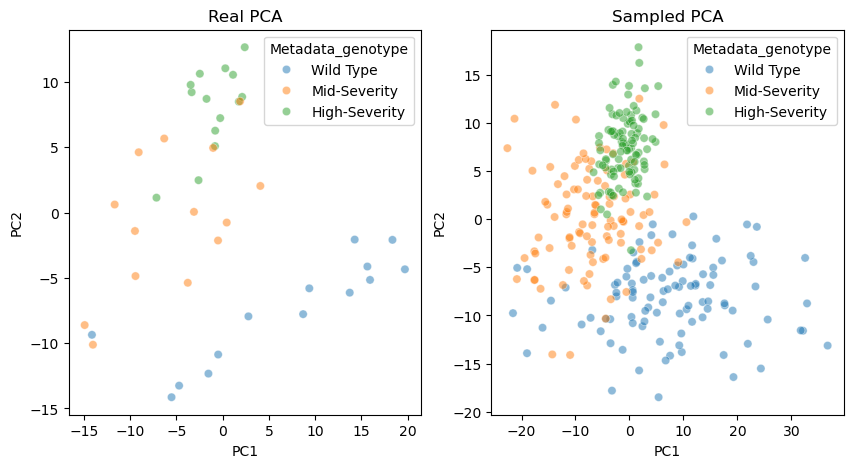

In [15]:
# Visualization of the last trial's sampled points

# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sum_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()